In [100]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score
import matplotlib.pyplot as plt

RANDOM_SEED = 2023

mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')


X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## What's the shape of the data

Here MNIST is a set of 70,000 images each 28 X 28 pixels.

The target labels (y) are the actual number that each image represents.

In [101]:
print(X)
print(X.shape)
print(y.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(70000, 784)
(70000,)


## View one digit of the set

1. Grab one of the records, each one being an image
2. Reshape it to 28 x 28
3. Plot using `plt.imshow()`

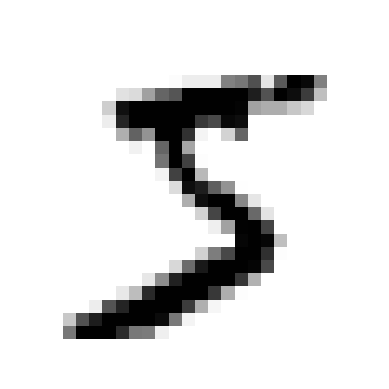

The image label: 5


In [102]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis("off")

some_digit = X[0] # first image
plot_digit(some_digit)
plt.show()

print(f'The image label: {y[0]}')

## Now split the data into train and test sets
This set is already pre-shuffled and split into training sets (first 60000) and test sets (10000)


In [103]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## First try a Binary Classifier

In this case we will first try to just classify whether an image represents a 5 or not

In [104]:
y_train_5 = (y_train == '5')
print(y_train_5.shape)
y_test_5 = (y_test == '5')
print(y_test_5.shape)

(60000,)
(10000,)


In [105]:
# fit the classifier to the data
sgd_clf = SGDClassifier(random_state=RANDOM_SEED)
sgd_clf.fit(X_train, y_train_5)

# Check to see if it correctly predicts our random image of '5'
some_digit_prediction = sgd_clf.predict([some_digit])
print(f'Initial prediction for y[0]: {some_digit_prediction}')

Initial prediction for y[0]: [ True]


## Try to measure accuracy using cross validation
Number of folds: 3

The accuracy of the SGD classifier is about 95%.

But that's not much better than a simple DummyClassifier, which has an accuracy of 90%.


The reason for this is that only about 10% of the data is actually a 5, so even if we guess
non-5 for every instance, we'd still be 90% accurate, which is what cross validation is showing.

In [106]:
# Check the ratio of 5's to non-5s in our training set.
print('+++++++++++++++++++++++')
s = pd.Series(y_train_5)
print(s.value_counts(normalize=True))

print('+++++++++++++++++++++++')
cv_result1 = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')
print(cv_result1)

print('+++++++++++++++++++++++')
# Compare with DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
dummy_cv_result1 = cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')
print(dummy_cv_result1)

+++++++++++++++++++++++
False    0.90965
True     0.09035
Name: proportion, dtype: float64
+++++++++++++++++++++++
[0.9587  0.9572  0.96035]
+++++++++++++++++++++++
[0.90965 0.90965 0.90965]


## Confusion Matrix

The confusion matrix will help shine some light on the true performance of the model

We can look at the _precision_, _recall_ and _f1_score_, which is also known as the harmonic mean of _precision_ and _recall_

The precision is basically saying: "When the model makes a positive prediction, it gets it right x% of the time".
- Our model gets it right ~ 76% of the time

The recall is basically saying: "Out of all the instances in the positive class, the model detects x% of them"
- Our model detects the positive class instances ~ 80% of them

In [107]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
cm = confusion_matrix(y_train_5, y_train_pred)
print('+++++++++++++++++++++++')
print(cm)

+++++++++++++++++++++++
[[53205  1374]
 [ 1101  4320]]


In [108]:
precision = precision_score(y_train_5, y_train_pred)
print('+++++++++++++++++++++++')
print(f'precision score: {precision}')

print('+++++++++++++++++++++++')
recall = recall_score(y_train_5, y_train_pred)
print(f'recall score: {recall}')


print('+++++++++++++++++++++++')
f1 = f1_score(y_train_5, y_train_pred)
print(f'f1 score: {f1}')

+++++++++++++++++++++++
precision score: 0.7586933614330874
+++++++++++++++++++++++
recall score: 0.7969009407858328
+++++++++++++++++++++++
f1 score: 0.777327935222672


## Precision and Recall tradeoff

It's not possible to have perfect precision and recall.  If the precision goes up, the recall will do down and vice versa.

Each classifier has a decision function which calculates a score for each instance.  If the score is above a certain threshold,
then it detects positive class, otherwise negative.

We can view the impact of the threshold on precision and recall

In [109]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
print('+++++++++++++++++++++++')
print(y_scores)

+++++++++++++++++++++++
[ 10039.29544457 -16735.6013513  -32307.88690651 ...  12201.58775094
  -6858.53784519  -9365.72501489]


### Pick a threshold

A graph like this one below can help us pick an appropriate threshold for our use-case

In this case with a threshold = 3000, the precision is near 90%, but the recall is close to 65%

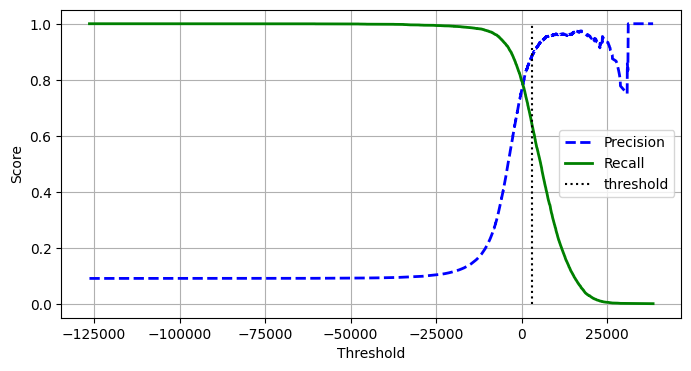

In [110]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

fig1, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
ax1.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

threshold = 3000
ax1.vlines(threshold, 0, 1.0, "k", "dotted", label='threshold')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score')
ax1.legend()
ax1.grid()

plt.show()

### Plot precision directly against recall

This is another way of seeing how precision and recall are related

Here let's suppose we decide on a target precision of 90%
Based on the graph, then it looks like recall would be around 60%

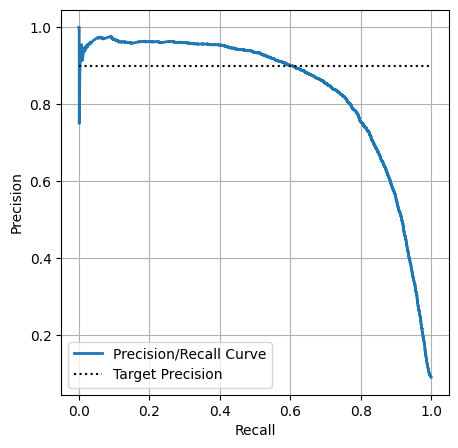

In [111]:
fig2, ax2 = plt.subplots(figsize=(5, 5))
ax2.plot(recalls, precisions, linewidth=2, label="Precision/Recall Curve")
ax2.hlines(0.90, 0, 1.0, "k", "dotted", label="Target Precision")
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend()
ax2.grid()

plt.show()

### Make Predictions based on classifier

With a target precision, we can find the corresponding threshold

Then with the threshold, we can calculate a new set of predictions and confirm precision and recall scores

In [112]:
# find the index of the precision >= 90%
idx_90_precision = (precisions >= 0.90).argmax()
# find the corresponding threshold
threshold_90_precisions = thresholds[idx_90_precision]
print('+++++++++++++++++++++++')
print(f'Target threshold for 90% precision: {threshold_90_precisions}')

# make new predictions
y_train_pred_90 = (y_scores >= threshold_90_precisions)

# recalculate scores based on new predictions
precision_90 = precision_score(y_train_5, y_train_pred_90)
recall_90 = recall_score(y_train_5, y_train_pred_90)
print('+++++++++++++++++++++++')
print(f'Precision: {precision_90}, Recall: {recall_90}')

+++++++++++++++++++++++
Target threshold for 90% precision: 3693.829372325985
+++++++++++++++++++++++
Precision: 0.9001097694840834, Recall: 0.6050544180040582


## Second Classifier: Random Forest

Compare a RandomForestClassifier with the SGDClassifier

Looks like RandomForestClassifier is significantly better than the SGDClassifier, the AUC for random forest is greater than for SGD

In [113]:
forest_clf = RandomForestClassifier(random_state=RANDOM_SEED)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

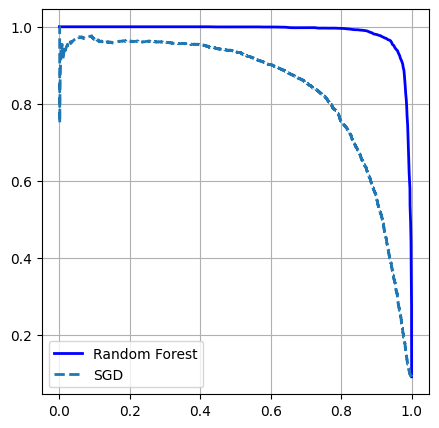

In [114]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)


fig3, ax3 = plt.subplots(figsize=(5, 5))
ax3.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
ax3.plot(recalls, precisions, "--", linewidth=2, label="SGD")
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax3.legend()
ax3.grid()

plt.show()

In [115]:
# make predications based on the pred_proba values

y_train_pred_forest = (y_probas_forest[:, 1] >= 0.5)
f1_score_forest = f1_score(y_train_5, y_train_pred_forest)
roc_auc_score_forest = roc_auc_score(y_train_5, y_scores_forest)

print('+++++++++++++++++++++++')
print(f'F1 Score Forest: {f1_score_forest}, ROC AUC Score Forest: {roc_auc_score_forest}')


+++++++++++++++++++++++
F1 Score Forest: 0.9270445185330457, ROC AUC Score Forest: 0.9982699319743729
